<a href="https://colab.research.google.com/github/atstuyuki/mediapipe/blob/main/mediapipe_shoulderAbduction_create_regressionmodel_20221227.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
%config InlineBackend.figure_formate ={'png', 'retina'}
import os
import sys
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
#google driveのマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#googledriveをマウントしている場合はここはスキップ可能

#ファイルタブからCSVを作業ディレクトリにUpLoad
#CSVファイルをup_load

from google.colab import files
import os
uploaded = files.upload()
#uploadedは辞書型なのでファイル名を取り出し、絶対パスを取得してfullpathという変数を当てる
for k in uploaded.keys():
  print('file name:',k)
fullpath_csv=os.path.abspath(k)
print('fullpath:',fullpath_csv)

KeyboardInterrupt: ignored

In [6]:
!pwd

/content


In [19]:
#googleドライブにデータを置いている場合は、データのパスをfullpathとして格納
fullpath= "./drive/MyDrive/臨床研究_発表/mediapipe/shoulder_abduction_dataset/右1213verCSV.csv"

In [35]:
df=pd.read_csv(fullpath,sep=',',encoding='UTF-8')#CSVをデータフレームに読み込む
df.head()

,Source.Name,deltatime,true_angle,cam_angle,is_right_hand,rtshoulderAngle,rtshoulderAbduction,rtshoulder_3DAngle,rtshoulder_3DAbduction,ltshoulderAngle,...,RIGHT_HEEL_z,RIGHT_HEEL_visibility,LEFT_FOOT_INDEX_x,LEFT_FOOT_INDEX_y,LEFT_FOOT_INDEX_z,LEFT_FOOT_INDEX_visibility,RIGHT_FOOT_INDEX_x,RIGHT_FOOT_INDEX_y,RIGHT_FOOT_INDEX_z,RIGHT_FOOT_INDEX_visibility
0,RtE(45)-90.csv,8.721623,90,45,1,143.478320,67.021408,149.023116,78.009392,89.154424,...,0.328475,0.929015,0.155033,0.784400,0.321462,0.976108,0.011960,0.818818,0.246544,0.985319
1,RtE(45)-90.csv,8.835132,90,45,1,143.379477,66.973739,146.980369,76.128404,87.688975,...,0.317863,0.924309,0.146333,0.795836,0.307153,0.976509,-0.001083,0.824013,0.231729,0.985426
2,RtE(45)-90.csv,8.951273,90,45,1,142.524776,63.401571,151.229125,80.629034,88.996475,...,0.345174,0.910657,0.141421,0.781295,0.335177,0.970458,0.021298,0.810393,0.266127,0.979177
3,RtE(45)-90.csv,9.067623,90,45,1,140.666310,62.646270,148.650732,77.520483,89.028779,...,0.321050,0.899602,0.141123,0.792684,0.317534,0.968415,0.010894,0.817801,0.239017,0.977301
4,RtE(45)-90.csv,9.179881,90,45,1,140.439885,64.916662,147.266296,76.400231,90.906571,...,0.311220,0.895687,0.146419,0.793155,0.332276,0.962742,0.024946,0.819602,0.228542,0.974592


In [36]:
#dfの型の確認　object型等は変更する必要がある
df.dtypes

Source.Name                     object
deltatime                      float64
true_angle                       int64
cam_angle                        int64
is_right_hand                    int64
                                ...   
LEFT_FOOT_INDEX_visibility     float64
RIGHT_FOOT_INDEX_x             float64
RIGHT_FOOT_INDEX_y             float64
RIGHT_FOOT_INDEX_z             float64
RIGHT_FOOT_INDEX_visibility    float64
Length: 153, dtype: object

In [37]:
#解析に必要な列のみ抽出してdfとして再度定義
df=df[['true_angle','cam_angle','is_right_hand','rtshoulderAngle','rtshoulderAbduction','rtshoulder_3DAngle','rtshoulder_3DAbduction','ltshoulderAngle',	'ltshoulderAbduction',	'ltshoulder_3DAngle',	'ltshoulder_3DAbduction',	'rtelbowhip_distratio',	'ltelbowhip_distratio',	'rtarm_distratio',	'ltarm_distratio',	'rtshoulder_distratio',	'ltshoulder_distratio',	'rthip_distratio',	'lthip_distratio']]

In [38]:
# データフレームの統計量記述
#min maxの外れ値をチェックして、外れ値があればもとのCSVデータをチェックしておく
df.describe()

,true_angle,cam_angle,is_right_hand,rtshoulderAngle,rtshoulderAbduction,rtshoulder_3DAngle,rtshoulder_3DAbduction,ltshoulderAngle,ltshoulderAbduction,ltshoulder_3DAngle,ltshoulder_3DAbduction,rtelbowhip_distratio,ltelbowhip_distratio,rtarm_distratio,ltarm_distratio,rtshoulder_distratio,ltshoulder_distratio,rthip_distratio,lthip_distratio
count,66031.000000,66031.000000,66031.0,66031.000000,66031.000000,66031.000000,66031.000000,66031.000000,66031.000000,66031.000000,66031.000000,66031.000000,66031.000000,66031.000000,66031.000000,66031.000000,66031.000000,66031.000000,66031.000000
mean,83.614666,4.002893,1.0,139.513372,77.998043,138.085349,78.089387,100.632096,11.333606,104.240003,17.971411,0.949312,0.560235,0.439830,0.491942,0.622030,0.491942,0.425330,0.452276
std,45.807189,27.212167,0.0,23.800296,45.748949,22.175318,43.584842,13.347227,8.556059,9.374676,10.231043,0.285032,0.071094,0.068736,0.039045,0.052627,0.039045,0.033964,0.019343
min,10.000000,-30.000000,1.0,14.565577,0.410607,30.155398,4.354781,0.027357,0.003585,65.302132,0.141030,0.387129,0.412340,0.088570,0.068260,0.088764,0.068260,0.049016,0.054158
25%,40.000000,-15.000000,1.0,120.251464,37.083353,119.150623,38.269808,92.993949,7.739401,96.229010,12.802576,0.678125,0.523809,0.384783,0.464624,0.582229,0.464624,0.399865,0.441942
50%,80.000000,0.000000,1.0,142.281706,73.367339,141.548342,75.782034,100.728324,10.830679,104.658653,16.527156,0.985844,0.548775,0.432272,0.490036,0.630519,0.490036,0.432286,0.451090
75%,120.000000,30.000000,1.0,158.465592,119.659572,156.136593,117.646394,109.998812,13.737781,111.554781,20.199832,1.218564,0.579872,0.498305,0.516914,0.665351,0.516914,0.452092,0.462109
max,160.000000,45.000000,1.0,179.997744,174.136480,179.919195,170.910872,177.290827,163.585778,171.823719,157.667726,1.433700,1.423679,0.630424,0.634940,0.740638,0.634940,0.501618,0.550041


In [39]:
#is_right_handをdropしておく
#今回の解析に不要な列をdrop 

df=df.drop(['is_right_hand'],axis='columns') 

In [40]:
#カメラアングル毎にデータフレームを作り直す
df_45=df.query('cam_angle == 45')
df_30=df.query('cam_angle == 30')
df_15=df.query('cam_angle == 15')
df_0=df.query('cam_angle == 0')
df_minus30=df.query('cam_angle == -30')
df_minus15=df.query('cam_angle == -15')

In [41]:
#各データフレームの統計量を抽出
print('cam_angle45の統計特徴量',df_45.describe())
"""print('cam_angle30の統計特徴量',df_30.describe())
print('cam_angle15の統計特徴量',df_15.describe())
print('cam_angle0の統計特徴量',df_0.describe())
print('cam_angle -15の統計特徴量',df_minus15.describe())
print('cam_angle -30の統計特徴量',df_minus30.describe())"""

cam_angle45の統計特徴量          true_angle  cam_angle  rtshoulderAngle  rtshoulderAbduction  \
count  12618.000000    12618.0     12618.000000         12618.000000   
mean      85.131558       45.0       140.203714            77.990942   
std       45.232425        0.0        19.836290            44.132111   
min       10.000000       45.0        64.878622             0.410607   
25%       50.000000       45.0       124.900640            41.355073   
50%       80.000000       45.0       138.333012            63.569747   
75%      120.000000       45.0       154.255144           118.529282   
max      160.000000       45.0       179.997744           169.771317   

       rtshoulder_3DAngle  rtshoulder_3DAbduction  ltshoulderAngle  \
count        12618.000000            12618.000000     12618.000000   
mean           139.563509               80.307365        87.572915   
std             21.889940               40.840355        17.962120   
min             97.235756               18.519666    

"print('cam_angle30の統計特徴量',df_30.describe())\nprint('cam_angle15の統計特徴量',df_15.describe())\nprint('cam_angle0の統計特徴量',df_0.describe())\nprint('cam_angle -15の統計特徴量',df_minus15.describe())\nprint('cam_angle -30の統計特徴量',df_minus30.describe())"

In [42]:
df_30.describe()

,true_angle,cam_angle,rtshoulderAngle,rtshoulderAbduction,rtshoulder_3DAngle,rtshoulder_3DAbduction,ltshoulderAngle,ltshoulderAbduction,ltshoulder_3DAngle,ltshoulder_3DAbduction,rtelbowhip_distratio,ltelbowhip_distratio,rtarm_distratio,ltarm_distratio,rtshoulder_distratio,ltshoulder_distratio,rthip_distratio,lthip_distratio
count,7313.000000,7313.0,7313.000000,7313.000000,7313.000000,7313.000000,7313.000000,7313.000000,7313.000000,7313.000000,7313.000000,7313.000000,7313.000000,7313.000000,7313.000000,7313.000000,7313.000000,7313.000000
mean,77.993983,30.0,136.960844,74.834419,135.422469,75.651918,96.271086,8.084526,102.555082,13.549396,0.932417,0.551773,0.466190,0.478419,0.633917,0.478419,0.434238,0.455131
std,46.879472,0.0,21.601863,45.485987,22.732765,44.221211,8.881103,3.697530,9.614569,6.875732,0.296052,0.036291,0.062670,0.019863,0.051621,0.019863,0.030660,0.016328
min,10.000000,30.0,100.469390,13.068477,97.262947,13.841907,75.074080,0.003884,86.897375,4.164398,0.481287,0.487701,0.320207,0.291357,0.506831,0.291357,0.352502,0.398147
25%,40.000000,30.0,117.667975,31.947918,113.396740,32.474563,89.315028,6.050253,94.942531,8.505954,0.623567,0.530666,0.408638,0.467442,0.587747,0.467442,0.408696,0.443297
50%,70.000000,30.0,136.590217,65.476020,137.349629,67.765166,93.260591,7.586560,99.092208,12.102682,0.930126,0.543029,0.475131,0.477708,0.651388,0.477708,0.443880,0.454029
75%,120.000000,30.0,153.905800,117.103600,154.741693,117.801166,103.278522,10.019073,110.180078,16.172869,1.224607,0.561814,0.527804,0.490107,0.675660,0.490107,0.459521,0.465930
max,160.000000,30.0,179.981662,166.801857,179.736694,162.355379,122.203134,19.595796,133.457260,79.941275,1.433700,1.024154,0.571088,0.577145,0.728467,0.577145,0.488298,0.550041


In [43]:
df_15.describe()

,true_angle,cam_angle,rtshoulderAngle,rtshoulderAbduction,rtshoulder_3DAngle,rtshoulder_3DAbduction,ltshoulderAngle,ltshoulderAbduction,ltshoulder_3DAngle,ltshoulder_3DAbduction,rtelbowhip_distratio,ltelbowhip_distratio,rtarm_distratio,ltarm_distratio,rtshoulder_distratio,ltshoulder_distratio,rthip_distratio,lthip_distratio
count,7607.000000,7607.0,7607.000000,7607.000000,7607.000000,7607.000000,7607.000000,7607.000000,7607.000000,7607.000000,7607.000000,7607.000000,7607.000000,7607.000000,7607.000000,7607.000000,7607.000000,7607.000000
mean,84.823189,15.0,143.392122,80.142142,140.065692,79.157884,97.685385,9.264492,99.172083,13.485203,0.962350,0.566299,0.442351,0.459060,0.639785,0.459060,0.428870,0.450850
std,45.429463,0.0,22.168733,42.232864,20.583179,42.223160,7.700939,3.011027,8.012812,4.454482,0.273918,0.025856,0.055928,0.024078,0.053951,0.024078,0.031971,0.015661
min,10.000000,15.0,100.402778,14.262177,98.338077,14.467788,82.096108,0.020298,83.161096,1.700765,0.488400,0.485768,0.335662,0.402028,0.502434,0.402028,0.348828,0.407874
25%,50.000000,15.0,126.352023,41.205376,124.225935,40.312095,90.794768,7.155434,91.998847,10.725004,0.706064,0.548839,0.390798,0.441362,0.603906,0.441362,0.405598,0.439007
50%,80.000000,15.0,145.378421,78.258672,142.868498,76.089690,97.115802,9.268555,98.801117,13.028442,0.989930,0.566407,0.439443,0.457106,0.662043,0.457106,0.435045,0.449183
75%,120.000000,15.0,161.635146,114.496262,156.248798,113.213079,104.329324,11.489945,106.262114,15.301531,1.196757,0.584691,0.489990,0.473879,0.675335,0.473879,0.453271,0.461427
max,160.000000,15.0,179.995377,160.531438,179.919195,161.962705,116.628019,18.132857,116.799104,35.277649,1.399371,0.659844,0.558335,0.543703,0.740638,0.543703,0.488896,0.508299


In [44]:
df_0.describe()

,true_angle,cam_angle,rtshoulderAngle,rtshoulderAbduction,rtshoulder_3DAngle,rtshoulder_3DAbduction,ltshoulderAngle,ltshoulderAbduction,ltshoulder_3DAngle,ltshoulder_3DAbduction,rtelbowhip_distratio,ltelbowhip_distratio,rtarm_distratio,ltarm_distratio,rtshoulder_distratio,ltshoulder_distratio,rthip_distratio,lthip_distratio
count,10591.000000,10591.0,10591.000000,10591.000000,10591.000000,10591.000000,10591.000000,10591.000000,10591.000000,10591.000000,10591.000000,10591.000000,10591.000000,10591.000000,10591.000000,10591.000000,10591.000000,10591.000000
mean,87.602682,0.0,143.201545,87.209324,141.944135,83.992470,104.507041,12.467023,104.113226,21.625585,0.992420,0.587150,0.439880,0.477213,0.638579,0.477213,0.427071,0.452822
std,45.031132,0.0,23.396440,44.443854,21.995084,43.074288,8.805782,6.783272,8.254651,8.396029,0.276909,0.056079,0.058248,0.028868,0.058242,0.028868,0.040661,0.028429
min,10.000000,0.0,14.565577,0.450281,30.155398,4.354781,58.696624,0.416954,89.710894,1.546852,0.461185,0.462073,0.088570,0.068260,0.088764,0.068260,0.049016,0.054158
25%,50.000000,0.0,126.442132,46.356945,126.290294,44.457511,96.275634,9.983022,96.172792,17.906203,0.738285,0.561100,0.398710,0.457303,0.614668,0.457303,0.407399,0.445722
50%,90.000000,0.0,145.542828,89.218526,145.397056,86.296703,105.703877,12.625796,105.459869,20.331821,1.053198,0.585311,0.427466,0.478327,0.662319,0.478327,0.433890,0.456137
75%,130.000000,0.0,162.789490,125.608476,160.673283,119.407246,110.310604,14.560877,109.384436,23.968710,1.246972,0.607370,0.488045,0.495170,0.679122,0.495170,0.458542,0.464532
max,160.000000,0.0,179.987994,174.136480,179.792794,170.910872,177.290827,153.916438,171.823719,153.656002,1.416234,1.386613,0.594496,0.580310,0.720983,0.580310,0.488262,0.501823


In [45]:
df_minus15.describe()

,true_angle,cam_angle,rtshoulderAngle,rtshoulderAbduction,rtshoulder_3DAngle,rtshoulder_3DAbduction,ltshoulderAngle,ltshoulderAbduction,ltshoulder_3DAngle,ltshoulder_3DAbduction,rtelbowhip_distratio,ltelbowhip_distratio,rtarm_distratio,ltarm_distratio,rtshoulder_distratio,ltshoulder_distratio,rthip_distratio,lthip_distratio
count,13338.000000,13338.0,13338.000000,13338.000000,13338.000000,13338.000000,13338.000000,13338.000000,13338.000000,13338.000000,13338.000000,13338.000000,13338.000000,13338.000000,13338.000000,13338.000000,13338.000000,13338.000000
mean,84.490928,-15.0,140.593594,79.181116,139.580226,78.976569,107.239132,13.365165,106.434326,18.844711,0.949411,0.548569,0.422280,0.509513,0.621842,0.509513,0.422337,0.459539
std,45.566748,0.0,25.140640,45.411381,22.483557,43.779355,8.525032,3.699336,8.310415,7.934658,0.280295,0.059307,0.072427,0.032071,0.051014,0.032071,0.035348,0.018997
min,10.000000,-15.0,92.727806,5.857233,93.484885,8.323762,87.133213,4.295184,86.447972,8.479923,0.387129,0.417516,0.291260,0.333361,0.489563,0.333361,0.345387,0.416091
25%,50.000000,-15.0,118.878127,38.627226,121.235822,38.835894,99.338248,11.653266,98.328106,14.179414,0.685881,0.515830,0.361454,0.487163,0.581572,0.487163,0.395409,0.444939
50%,80.000000,-15.0,146.543516,78.506593,143.659718,77.994774,107.477060,13.164971,107.335423,16.471428,0.993939,0.540060,0.398759,0.507232,0.634660,0.507232,0.429301,0.455640
75%,120.000000,-15.0,159.846915,122.246021,157.224728,119.737113,114.008845,14.857720,112.943587,20.166671,1.211294,0.568857,0.489004,0.525501,0.657960,0.525501,0.450527,0.470368
max,160.000000,-15.0,179.967310,156.637707,179.734022,154.090410,154.940752,69.810468,132.062940,88.338202,1.361296,1.052338,0.630424,0.623623,0.721894,0.623623,0.491395,0.524387


In [46]:
df_minus30.describe()

,true_angle,cam_angle,rtshoulderAngle,rtshoulderAbduction,rtshoulder_3DAngle,rtshoulder_3DAbduction,ltshoulderAngle,ltshoulderAbduction,ltshoulder_3DAngle,ltshoulder_3DAbduction,rtelbowhip_distratio,ltelbowhip_distratio,rtarm_distratio,ltarm_distratio,rtshoulder_distratio,ltshoulder_distratio,rthip_distratio,lthip_distratio
count,14564.000000,14564.0,14564.000000,14564.000000,14564.000000,14564.000000,14564.000000,14564.000000,14564.000000,14564.000000,14564.000000,14564.000000,14564.000000,14564.000000,14564.000000,14564.000000,14564.000000,14564.000000
mean,80.788932,-30.0,134.499694,70.690883,132.932280,71.728353,106.806514,11.606781,105.721790,16.799449,0.895180,0.516751,0.427041,0.531100,0.601186,0.531100,0.416532,0.447949
std,46.313700,0.0,26.682201,48.817721,21.726551,45.565805,9.155223,2.926228,7.885922,3.298115,0.293741,0.025383,0.085418,0.025832,0.035608,0.025832,0.030898,0.011659
min,10.000000,-30.0,88.906347,2.585953,94.725411,5.710817,85.577105,4.399874,91.087068,7.643166,0.415841,0.412340,0.129381,0.471713,0.502401,0.471713,0.338846,0.407620
25%,40.000000,-30.0,109.195917,24.896753,113.555880,27.984894,98.363198,9.318326,97.741228,14.479405,0.604446,0.503028,0.351461,0.511006,0.575928,0.511006,0.392505,0.440643
50%,80.000000,-30.0,138.703121,65.933800,136.952715,66.541577,108.094639,11.033299,107.491102,16.995682,0.918249,0.518469,0.410120,0.527863,0.612064,0.527863,0.418885,0.447900
75%,120.000000,-30.0,157.126175,117.995667,150.745244,115.762553,114.462237,13.639397,112.446215,18.777687,1.184283,0.531443,0.506037,0.545641,0.628652,0.545641,0.444557,0.454503
max,160.000000,-30.0,179.894630,167.639500,179.079925,156.817578,129.461651,21.837380,125.876152,35.979153,1.356772,0.656993,0.594901,0.634940,0.666421,0.634940,0.473947,0.513537


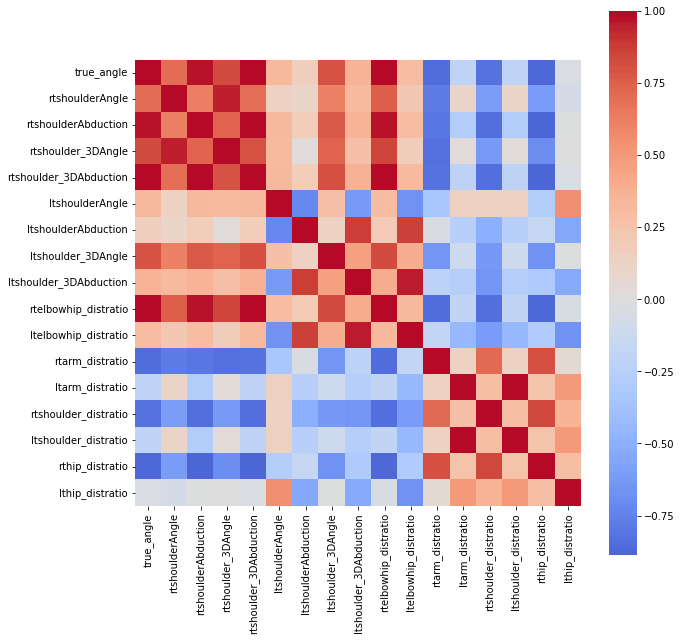

In [47]:
#まずカメラアングル45度のデータで分析してみる
#カメラアングルは予測パラメータに使用しないのでdropしておく
df_45=df_45.drop(['cam_angle'],axis='columns') 
#dfでの相関係数のheatmap 白黒表示であればcmap='binary'とする
plt.figure(figsize=(10,10))
cmap=sns.color_palette('coolwarm',200)
sns.heatmap(df_45.corr(),square=True,annot=False,cmap=cmap,center=0)

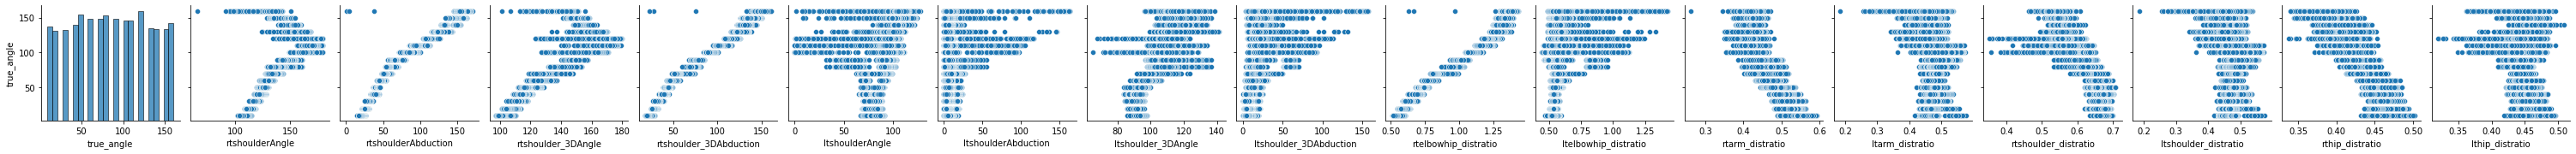

In [49]:
#dataの可視化　探索的データ解析'EDA'
#pair plot を試す　X軸にすべての項目　ｙ軸に目的変数('true_angle')を設定
sns.pairplot(df_45, x_vars=df_45[0:],y_vars='true_angle')
plt.show()

In [50]:
#自動化できるようにデータフレームの名前書き換え
df=df_45

In [51]:
#データセットの分割　正解クラス　説明変数の指定
#訓練データの不要な列を df.drop([],axis='columns')で指定 
train_x=df.drop(['true_angle'],axis='columns') 
train_y=df['true_angle']
(train_x,test_x,train_y,test_y)=train_test_split(train_x,train_y,test_size=0.1,random_state=0)

In [52]:
#データセットの形確認
print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(11356, 16)
(1262, 16)
(11356,)
(1262,)


In [53]:
#train学習データ 教師データ(np.arrayの内容表示）
print(train_x)
print(train_y)

       rtshoulderAngle  rtshoulderAbduction  rtshoulder_3DAngle  \
57607       139.888285            57.046261          148.518450   
15137       133.273480            50.120065          124.926117   
56223       163.030837           123.827898          164.946627   
15741       147.327958            59.805467          149.187909   
31556       115.168786            28.248334          110.971166   
...                ...                  ...                 ...   
32175       128.270877            46.324385          128.748873   
30580       173.872935            95.081113          171.292225   
57583       137.784669            55.356387          146.269540   
64212       176.525977           103.655935          177.132891   
15705       153.254334            63.237118          146.188132   

       rtshoulder_3DAbduction  ltshoulderAngle  ltshoulderAbduction  \
57607               76.030065        93.708505             7.880001   
15137               52.431385        70.413825       

In [54]:
#linerRegression の学習
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
"""#特徴量の標準化
sc=StandardScaler()
x_train_std=sc.fit_transform(train_x)
x_test_std=sc.transform(test_x)"""
#今回は特徴量がすべて角度であるので標準化せず
#modelの定義
model=LinearRegression()
model.fit(train_x,train_y)

LinearRegression()

In [55]:
print('モデルの傾き:',model.coef_)
print('モデルの切片:',model.intercept_)

モデルの傾き: [-5.39409945e-01  2.91667247e-01  2.39838295e-01 -8.56091517e-02
 -1.02957589e-01 -2.53359571e-01 -3.19386532e-01  2.13829997e-01
  1.53402954e+02 -1.09061054e+01 -1.16211773e+02  3.50029328e+01
  3.63241896e+01  3.50029328e+01  1.02672701e+02 -1.37309593e+02]
モデルの切片: 24.10977618918872


In [56]:
#pickleを使ってモデルを保存
import pickle
file = 'trained_liner_regression_model_20221227.pkl'
pickle.dump(model, open(file, 'wb'))


In [57]:
#pickleを使ってモデルを読み込み
model = pickle.load(open('trained_liner_regression_model_20221227.pkl', 'rb'))
model

LinearRegression()

In [58]:
#RMSEではなくMean absolute percentage error(MAPE)を計算する関数の作成
#MAPE=平均絶対パーセント誤差
def calc_mape(y_true, y_pred):
  data_num = len(y_true)
  mape= (np.sum(np.abs(y_pred-y_true)/y_true)/data_num)*100
  return mape

train_pred =model.predict(train_x)
train_mape =calc_mape(train_y.values, train_pred)
print(f'train mape: {train_mape:.3f}%')
#テストデータに対する評価
test_pred = model.predict(test_x)
test_mape = calc_mape(test_y.values,test_pred)

print(f'test mape:{test_mape:.3f}%')

train mape: 10.566%
test mape:10.778%


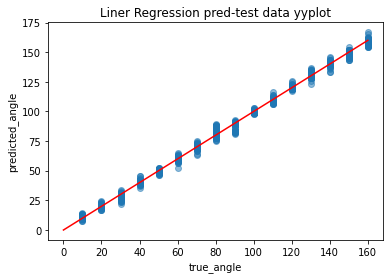

r2:0.998
相関係数:0.999


In [89]:
#x軸に実際の値　ｙ軸に予測値　肩外転角度20-150の範囲でプロット
#完全に一致なら赤線の上に点が収まるはず
import matplotlib.pyplot as plt
import numpy as np
plt.scatter(test_y, test_pred, alpha = 0.5)
plt.plot(np.linspace(0, 160, 130), np.linspace(0, 160, 130), "red")#基準線の描画
plt.xlabel('true_angle')
plt.ylabel('predicted_angle')
plt.title('Liner Regression pred-test data yyplot')
plt.show()

#決定係数（R^2）の計算
from sklearn.metrics import r2_score
r2= r2_score(test_y,test_pred)
print(f'r2:{r2:.3f}')
#相関係数の計算(決定係数の平方根)
cor=np.sqrt(r2)
print(f'相関係数:{cor:.3f}')

In [60]:
#LightGBMの学習
# train data からさらにvalidation dataを分ける
trn_x,val_x, trn_y, val_y = train_test_split(train_x, train_y,test_size=0.2, random_state=0 )
lgb_dataset_trn=lgb.Dataset(trn_x, label=trn_y, categorical_feature='auto')
lgb_dataset_val=lgb.Dataset(val_x, label= val_y, categorical_feature='auto')

params={
    'objective':'rmse',#‘metric’は、’mean_absolute_error’, ‘mean_squared_error’, ‘rmse’から選ぶ
    'larning_rate':0.1,
    'max_depth':3,
}

lgb_model=lgb.train(
    params=params,
    train_set=lgb_dataset_trn,
    valid_sets=[lgb_dataset_val],
    num_boost_round=1000,
    early_stopping_rounds=100,
    verbose_eval=100

)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 2.7391
[200]	valid_0's rmse: 2.49674
[300]	valid_0's rmse: 2.30827
[400]	valid_0's rmse: 2.18351
[500]	valid_0's rmse: 2.08687
[600]	valid_0's rmse: 2.02069
[700]	valid_0's rmse: 1.9803
[800]	valid_0's rmse: 1.94746
[900]	valid_0's rmse: 1.92215
[1000]	valid_0's rmse: 1.90354
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 1.90354


#pickleをつかってモデルを保存

In [61]:
import pickle
file = 'trained_lightGBM_20221227_model.pkl'
pickle.dump(lgb_model, open(file, 'wb'))


#pickleを使ってモデルを読み出し

In [62]:
lgb_model = pickle.load(open('trained_lightGBM_20221227_model.pkl', 'rb'))
lgb_model

In [63]:
#RMSEではなくMean absolute percentage error(MAPE)を計算する関数の作成
#MAPE=平均絶対パーセント誤差
def calc_mape(y_true, y_pred):
  data_num = len(y_true)
  mape= (np.sum(np.abs(y_pred-y_true)/y_true)/data_num)*100
  return mape

train_pred =lgb_model.predict(train_x)
train_mape =calc_mape(train_y.values, train_pred)

val_pred = lgb_model.predict(val_x)
val_mape = calc_mape(val_y.values, val_pred)

print(f'train mape: {train_mape:.3f}%')
print(f'valid mape:{val_mape: .3f}%')

train mape: 1.867%
valid mape: 2.294%


In [64]:
#テストデータに対する評価
test_pred = lgb_model.predict(test_x)
test_mape = calc_mape(test_y.values,test_pred)

print(f'test mape:{test_mape:.3f}%')

test mape:2.371%


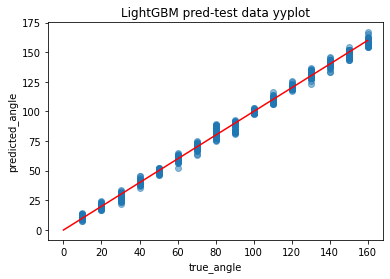

r2:0.998
相関係数:0.999


In [88]:
#x軸に実際の値　ｙ軸に予測値　肩外転角度20-150の範囲でプロット
#完全に一致なら赤線の上に点が収まるはず
import matplotlib.pyplot as plt
import numpy as np
plt.scatter(test_y, test_pred, alpha = 0.5)
plt.plot(np.linspace(0, 160, 130), np.linspace(0, 160, 130), "red")#基準線の描画
plt.xlabel('true_angle')
plt.ylabel('predicted_angle')
plt.title('LightGBM pred-test data yyplot')
plt.show()

#決定係数（R^2）の計算
from sklearn.metrics import r2_score
r2= r2_score(test_y,test_pred)
print(f'r2:{r2:.3f}')
#相関係数の計算(決定係数の平方根)
cor=np.sqrt(r2)
print(f'相関係数:{cor:.3f}')

#テストデータの真値と予測値をCSVに保存

In [66]:
result=np.vstack((test_pred, test_y))
result=result.T

In [67]:
np.savetxt('lightGBM_prediction_20221227.csv',result,delimiter = ',',fmt = '%s',header='prediction,true_value')

#LightGBMをoputunaにてハイパーパラメータチューニング

In [68]:
#optunaのlightGBM用のAPIによるハイパーパラメーターチューニング
#まず ！pipでインストール
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 5.2 MB/s 
     |████████████████████████████████| 210 kB 47.3 MB/s 
     |████████████████████████████████| 81 kB 9.3 MB/s 
     |████████████████████████████████| 78 kB 6.8 MB/s 
     |████████████████████████████████| 50 kB 6.3 MB/s 
     |████████████████████████████████| 147 kB 50.2 MB/s 
     |████████████████████████████████| 112 kB 46.0 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=6661576789df00bb1b5d75cc488af0d5cb77b78719cc468ac01fe4144c3401ca
  Stored in directory: /root/.cache/pip/wheels/7f/1a/65/84ff8c386bec21fca6d220ea1f5498a0367883a78dd5ba6122
Successfully built pyperclip
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 5.1.0
    Uninstalling importlib-metadata-5.1.0:
      Successfully uninstalled importlib-metadata-5.1.0


In [69]:
import optuna
import optuna.integration.lightgbm as lgbo

# 回帰の場合
opt_params = {
    "objective":"regression",
    "metric":"rmse"
}
#探索用にデータを作り直す
reg_train = lgb.Dataset(train_x,train_y,free_raw_data=False)
reg_eval = lgb.Dataset(test_x,test_y,free_raw_data=False)

#パラメータを探す
opt=lgbo.train(
    opt_params,
    reg_train,
    valid_sets = reg_eval,
    verbose_eval=False,
    #ラウンド数
    num_boost_round = 5,
    #打ち切り
    #early_stopping_rounds = 100
)

[I 2022-12-28 03:43:48,543] A new study created in memory with name: no-name-0e507cc3-f789-4dea-9fe7-e74d9a4be808
min_data_in_leaf, val_score: 26.732592: 100%|##########| 5/5 [00:02<00:00,  2.48it/s]


In [70]:
#最適なパラメータを取得 optunaでのベストモデルがoptになっている
opt.params

{'objective': 'regression',
 'metric': 'rmse',
 'feature_pre_filter': False,
 'lambda_l1': 0.0,
 'lambda_l2': 0.0,
 'num_leaves': 124,
 'feature_fraction': 0.8999999999999999,
 'bagging_fraction': 0.9245610483732203,
 'bagging_freq': 2,
 'min_child_samples': 5}

In [71]:
# 選んだパラメータで再度学習
opt_model = lgb.train(params=opt.params,
    train_set=reg_train,
    valid_sets=reg_eval,
    num_boost_round=1000,
    early_stopping_rounds=100,
    verbose_eval=100,)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 2.17238
Early stopping, best iteration is:
[45]	valid_0's rmse: 2.01328


In [72]:
#テストデータで予測して、予測値を算出
op_test_pred = opt_model.predict(test_x)
op_test_mape = calc_mape(test_y.values,op_test_pred)

print(f'Oputuna test mape:{op_test_mape:.3f}%')

Oputuna test mape:1.900%


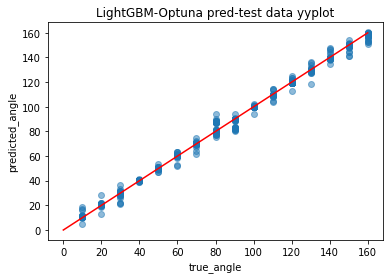

Oputuna test r2:0.998
Oputuna 相関係数:0.999


In [87]:
#x軸に実際の値　ｙ軸に予測値　YAM 40-120の範囲でプロット
#完全に一致なら赤線の上に点が収まるはず
import matplotlib.pyplot as plt
import numpy as np
plt.scatter(test_y, op_test_pred, alpha = 0.5)
plt.plot(np.linspace(0, 160, 130), np.linspace(0, 160, 130), "red")#基準線の描画
plt.xlabel('true_angle')
plt.ylabel('predicted_angle')
plt.title('LightGBM-Optuna pred-test data yyplot')
plt.show()

#決定係数（R^2）の計算
from sklearn.metrics import r2_score
op_r2= r2_score(test_y,op_test_pred)
print(f'Oputuna test r2:{op_r2:.3f}')
#相関係数の計算
op_cor = np.sqrt(op_r2)
print(f'Oputuna 相関係数:{op_cor:.3f}')

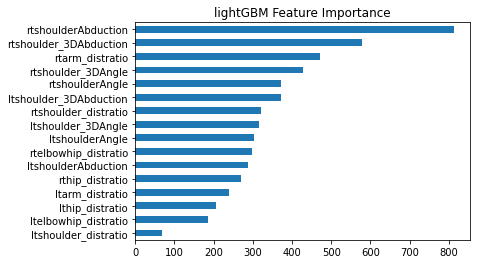

In [74]:
# feature importanceの可視化1　デフォルトの設定
feat_imp = pd.Series(opt_model.feature_importance(), index=test_x.columns).sort_values(ascending=False)
feat_imp = feat_imp.head(30)
feat_imp = feat_imp.sort_values(ascending=True)
feat_imp.plot(kind='barh', title='lightGBM Feature Importance', color=sns.color_palette()[0])
plt.show()

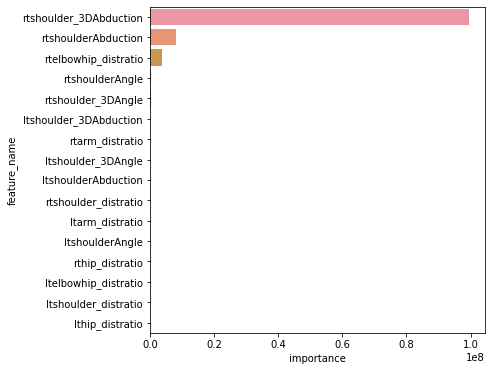

In [75]:
#feature importanceの可視化2
feature_importance = pd.DataFrame({
    'feature_name': opt_model.feature_name(),
    'importance': opt_model.feature_importance(importance_type='gain'),#importance_typeが異なる今回はgainを採用
})
feature_importance = feature_importance.sort_values('importance', ascending = False)

plt.figure(figsize= (6,6))
sns.barplot(data = feature_importance, x ='importance', y='feature_name')
plt.savefig('feature_importance.png')

#pickleによるoputunaモデルの保存と読みだし

In [76]:
#optunaでパラメータ調整したmodelの保存
import pickle
file = 'trained_oputuna_lightGBM_20221227_model.pkl'
pickle.dump(opt_model, open(file, 'wb'))

In [77]:
opt_model = pickle.load(open('trained_oputuna_lightGBM_20221227_model.pkl', 'rb'))
opt_model

#作成したモデルの解釈性としてSHAPを使用してみる

In [78]:
!pip install shap #shapをインストール

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 575 kB 4.4 MB/s 


In [79]:
#shapをインポートしてモデルのshap値を計算
import shap
lgb_explainer = shap.TreeExplainer(opt_model, train_x)
lgb_shap_values = lgb_explainer.shap_values(train_x)


 99%|===================| 11240/11356 [00:59<00:00]       

In [80]:
# jupyter notebookにコードを表示させるためにjsをロード
shap.initjs()

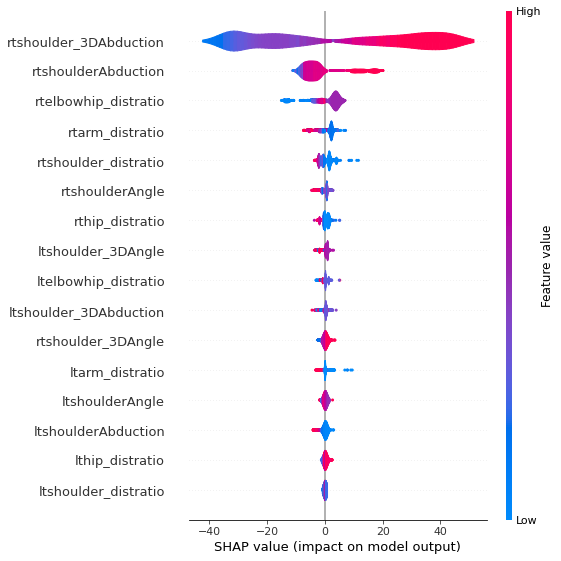

In [81]:
# LightGBMでのViolin Plotの可視化
shap.summary_plot(lgb_shap_values, train_x, plot_type="violin")#ploty type 'dot' or 'violin'

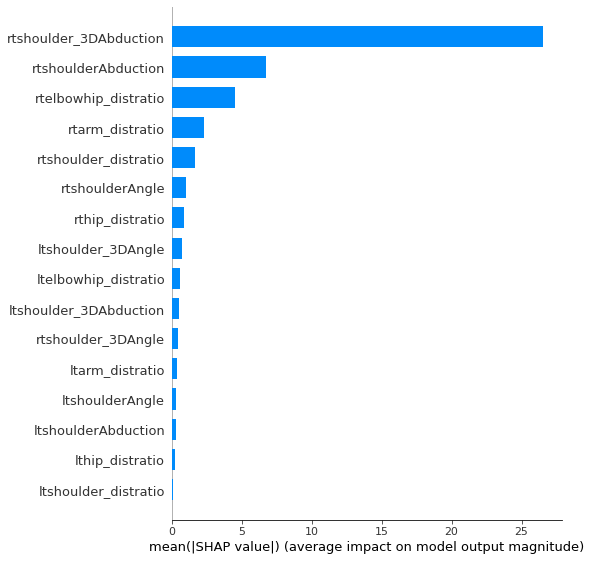

In [82]:
shap.summary_plot(lgb_shap_values, train_x, plot_type="bar")

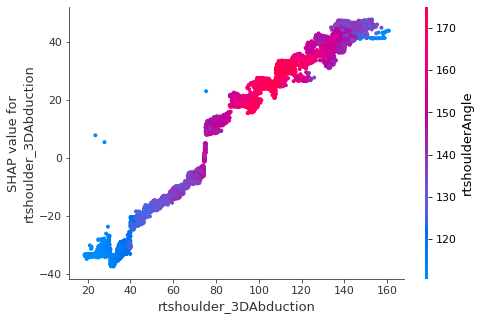

In [83]:
# LightGBMでのPartial Dependence Plotの可視化
#shap.dependence_plot("rank(1)",interaction_index='BMI',lgb_shap_values, train_x)
shap.dependence_plot(ind='rtshoulder_3DAbduction',
                     interaction_index='rtshoulderAngle',
                     shap_values=lgb_shap_values,
                     features=train_x,
                     feature_names=train_x.columns)

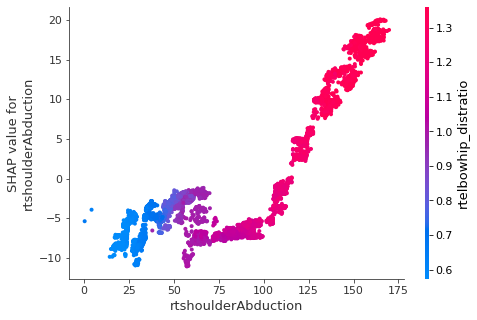

In [84]:
# LightGBMでのPartial Dependence Plotの可視化
shap.dependence_plot(ind='rtshoulderAbduction',
                     interaction_index='rtelbowhip_distratio',
                     shap_values=lgb_shap_values,
                     features=train_x,
                     feature_names=train_x.columns)

In [ ]:
#Force plotによる可視化
#google colabでは動かなかった　ローカルなら動くかも
#20220703時点では動くが重いのでデータ数を減らすこと
"""shap.force_plot(base_value=lgb_explainer.expected_value,
                shap_values=lgb_shap_values,
                features=train_x,
                feature_names=train_x.columns)"""

#XGBoostによる回帰モデルの作成

In [ ]:
#参考サイト　https://takaherox.hatenablog.com/entry/2020/07/06/234337
import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import classification_report

In [ ]:
# 固定パラメータの指定
SEED = 42
TEST_SIZE = 0.2
target = "class"
predictors = [i for i in df.columns if i not in target]

In [ ]:
## XGBoostモデル作成
params = {
    "objective" : "reg:squarederror",
    "eval_metric" : "rmse"
}

 # モデルの学習
xgb_train = xgb.DMatrix(train_x,train_y)
xgb_test = xgb.DMatrix(test_x, test_y)
evals_result = {}
xgb_model = xgb.train(
    params,
    xgb_train,
    num_boost_round=5000,  
    early_stopping_rounds=500,
    evals = [(xgb_test, 'eval'), (xgb_train, 'train')],
    evals_result=evals_result,
     verbose_eval=100
    
)             

In [ ]:
#trainデータに対してのloss推移をplot
plt.plot(evals_result['train']['rmse'], label='train rmse')
#testデータに対してのloss推移をplot
plt.plot(evals_result['eval']['rmse'], label='eval rmse')
plt.grid()
plt.legend()
plt.xlabel('rounds')
plt.ylabel('rmse')
plt.savefig("img.png", bbox_inches='tight')
plt.show()

In [ ]:
pred = xgb_model.predict(xgb_test)
print(pred)

In [ ]:
#実測値と予測値のyyplot
plt.scatter(test_y, pred, alpha = 0.5)
plt.plot(np.linspace(40, 120, 120), np.linspace(40, 120, 120), "red")
plt.xlabel('true_value')
plt.ylabel('predicted_value')
plt.title('XGBoostpred-test data yyplot')
plt.show()

#決定係数（R^2）の計算
from sklearn.metrics import r2_score
r2= r2_score(test_y,pred)
print(f'r2:{r2:.3f}')
#相関係数の計算(決定係数の平方根)
cor=np.sqrt(r2)
print(f'相関係数:{cor:.3f}')
#rmseの計算
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test_y, pred)
rmse = np.sqrt(mse)
print(f'rmse:{rmse:.3f}')

In [ ]:
#optunaによるXGBoostのハイパーパラメーターチューニング
#参考文献の都合でscikitlearnAPI使用
from xgboost import XGBRegressor

In [ ]:
# optunaの目的関数を設定する
#gtreeのパラメーター設定です。
'''def objective(trial):
    eta =  trial.suggest_loguniform('eta', 1e-8, 1.0)
    gamma = trial.suggest_loguniform('gamma', 1e-8, 1.0)
    max_depth = trial.suggest_int('max_depth', 1, 20)
    min_child_weight = trial.suggest_loguniform('min_child_weight', 1e-8, 1.0)
    max_delta_step = trial.suggest_loguniform('max_delta_step', 1e-8, 1.0)
    subsample = trial.suggest_uniform('subsample', 0.0, 1.0)
    reg_lambda = trial.suggest_uniform('reg_lambda', 0.0, 1000.0)
    reg_alpha = trial.suggest_uniform('reg_alpha', 0.0, 1000.0)


    regr =xgb.XGBRegressor(eta = eta, gamma = gamma, max_depth = max_depth,
                           min_child_weight = min_child_weight, max_delta_step = max_delta_step,
                           subsample = subsample,reg_lambda = reg_lambda,reg_alpha = reg_alpha)

    score = cross_val_score(regr, train_x, train_y, cv=5, scoring="r2")
    r2_mean = score.mean()
    print(r2_mean)

    return r2_mean'''

def objective(trial):

    params = {
        "silent": 1,
        "max_depth": trial.suggest_int("max_depth", 6, 9),
        "min_child_weight": 1,
        "eta": trial.suggest_loguniform("eta", 0.01, 1.0),
        "tree_method": "exact",
        "objective": "reg:linear",
        "eval_metric": "rmse",
        "predictor": "cpu_predictor"  
    }

    cv_results = xgb.cv(
        params,
        xgb_train,
        num_boost_round=1000,
        seed=0,
        nfold=5, # CVの分割数
        metrics={"rmse"},
        early_stopping_rounds=5
    )

    return cv_results["test-rmse-mean"].min()

In [ ]:
# optunaで最適値を見つける
import optuna
from sklearn.model_selection import cross_val_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=500)



In [ ]:
# チューニングしたハイパーパラメーターをフィット モデル名をop_xgbとする
op_xgb = xgb.XGBRegressor(eta = study.best_params['eta'],#gamma = study.best_params['gamma'],
                                max_depth = study.best_params['max_depth'],##min_child_weight = study.best_params['min_child_weight'],
                                #max_delta_step = study.best_params['max_delta_step'],subsample = study.best_params['subsample'],
                                reg_lambda = study.best_params['reg_lambda'],reg_alpha = study.best_params['reg_alpha'])

op_xgb.fit(train_x,train_y)

In [ ]:
#optunaによる最適化モデル(op_xgb)による予測
y_train_pred = op_xgb.predict(train_x)
y_test_pred = op_xgb.predict(test_x)

#評価指標の計算
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

print('MSE   train: %.3f,  test: %.3f' % (
        mean_squared_error(train_y, y_train_pred),
        mean_squared_error(test_y, y_test_pred)))
print('RMSE  train: %.3f,  test: %.3f' %(
        np.sqrt(mean_squared_error(train_y, y_train_pred)),
        np.sqrt(mean_squared_error(test_y, y_test_pred))))
print('R^2   train: %.3f,  test: %.3f' % (
        r2_score(train_y, y_train_pred),
        r2_score(test_y, y_test_pred)))

In [ ]:
#実測値と予測値のyyplot
plt.scatter(test_y, y_test_pred, alpha = 0.5)
plt.plot(np.linspace(40, 120, 120), np.linspace(40, 120, 120), "red")
plt.xlabel('true_value')
plt.ylabel('predicted_value')
plt.title('Optuna_XGBoostpred-test data yyplot')
plt.show()

#決定係数（R^2）の計算
from sklearn.metrics import r2_score
r2= r2_score(test_y,y_test_pred)
print(f'r2:{r2:.3f}')
#相関係数の計算(決定係数の平方根)
cor=np.sqrt(r2)
print(f'相関係数:{cor:.3f}')
#rmseの計算
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test_y, y_test_pred)
rmse = np.sqrt(mse)
print(f'rmse:{rmse:.3f}')

In [ ]:
# feature importanceの可視化

feat_imp = pd.Series(xgb_model.get_fscore()).sort_values(ascending=False)
feat_imp = feat_imp.head(30)
feat_imp = feat_imp.sort_values(ascending=True)
feat_imp.plot(kind='barh', title='XGBoost Feature Importance', color=sns.color_palette()[0])
plt.show()

In [ ]:
'''#Xgboost scikit learn APIによるgrid search 
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

xgb_reg = xgb.XGBRegressor()

params=[{'max_depth':[3,4,5,6],
        'n_estimators':[100,300,500]
       }]

scorer=make_scorer(mean_squared_error, False)

grid_xgb_reg=GridSearchCV(xgb_reg,
                          param_grid=params,
                          scoring=scorer,
                          cv=5,
                          n_jobs=-1)

grid_xgb_reg.fit(train_x, train_y)

y_train_pred = grid_xgb_reg.predict(train_x)
y_test_pred = grid_xgb_reg.predict(test_x)

# 最良スコアとなるパラメータ値を出力
print(grid_xgb_reg.best_params_)'''

In [ ]:
#評価指標の計算
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

print('MSE   train: %.3f,  test: %.3f' % (
        mean_squared_error(train_y, y_train_pred),
        mean_squared_error(test_y, y_test_pred)))
print('RMSE  train: %.3f,  test: %.3f' %(
        np.sqrt(mean_squared_error(train_y, y_train_pred)),
        np.sqrt(mean_squared_error(test_y, y_test_pred))))
print('R^2   train: %.3f,  test: %.3f' % (
        r2_score(train_y, y_train_pred),
        r2_score(test_y, y_test_pred)))

In [ ]:
#もう一度grid serachを実行
# 調整するハイパーパラメータの値の候補を設定
#この総当たり法は無限に時間がかかる
'''from xgboost import XGBRegressor
test_params = {'n_estimators':[100,200,300,400,500],
               'max_depth':[2,3,4,6,10],
    'min_child_weight':[1,2,3,4,6,10],
    'gamma':[0.0,0.1,0.2,2.0,10.0],
    'subsample':[0.5,0.6,0.7,0.8,0.9,1.0],
    'colsample_bytree':[0.5,0.6,0.7,0.8,0.9,1.0],
    'reg_alpha':[100,1,0,.1,.01,.001,.0001],
    'reg_lambda':[100,1,0,.1,.01,.001,.0001],
    'learning_rate':[.1,.8,0.5,0.3,.01,.001,.0001]
}

# グリッドサーチCVの実行
gridsearch = GridSearchCV(estimator = XGBRegressor( seed=42),
                           param_grid = test_params, scoring='explained_variance',
                           cv = 5, return_train_score=False)

gridsearch.fit(train_x,train_y,n_jobs=-1, verbose=100,)'''

In [ ]:
gridsearch.best_params_
xgb_best= gridsearch.best_estimator_

In [ ]:
# XgboostのSHAP Valueの計算
xgb_explainer = shap.TreeExplainer(xgb_model)#オリジナルAPIもしくはscikit learn API のモデルを渡す
xgb_shap_values = xgb_explainer.shap_values(train_x)


In [ ]:
# XgboostでのViolin Plotの可視化
shap.summary_plot(xgb_shap_values,train_x,plot_type='violin')

In [ ]:
# XgboostでのPartial Dependence Plotの可視化
shap.dependence_plot("rank(1)", xgb_shap_values, train_x)